# IMPORTS & FUNCTIONS

In [1]:
# Trying to find correlations and relationships between different metrics in nationwide data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from datetime import date, datetime, timedelta
from statistics import geometric_mean, harmonic_mean
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# STATE LEVEL METRICS

In [2]:
gdp = pd.read_csv('./data/data_raw/nominal_gdp.csv', header=4).dropna(axis=0, how='any')

gdp = gdp.drop(columns=['GeoFips']).set_index('GeoName').T

# citation: https://stackoverflow.com/questions/54076122/how-to-convert-date-format-qq-yyyy-to-a-datetime-object

gdp.index = pd.to_datetime(gdp.reset_index()['index'].str.replace(r'(\d+):(Q\d)', r'\1-\2', regex=True))

for c in gdp.columns:
    gdp[c] = gdp[c].apply(lambda x: x/3)

# compared both approaches
# gdp.resample('M').mean().interpolate('linear').plot()
# gdp.resample('M').mean().ffill().rolling(3).mean().plot()

gdp.reset_index().rename(columns={'period':'index'}).to_csv('./data/nominal_gdp_by_state.csv', index=False)

gdp.index.name = None

gdp = gdp.resample('M').mean().interpolate('linear')

gdp.index = pd.Series(pd.to_datetime(gdp.reset_index()['index'])).apply(lambda x: x + relativedelta(months=2))

In [3]:
pi = pd.read_csv('./data/data_raw/personal_income.csv', header=4)

pi['GeoName'] = pi['GeoName'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == ' *' else x)

for c in pi.columns:
    pi[c] = pi[c].apply(lambda x: np.NaN if x == '(NA)' else x)

income_pi = pi[pi['LineCode'] == 1].drop(columns=['GeoFips','LineCode','Description']).set_index('GeoName').T
pop_pi = pi[pi['LineCode'] == 2].drop(columns=['GeoFips','LineCode','Description']).set_index('GeoName').T
pci_pi = pi[pi['LineCode'] == 3].drop(columns=['GeoFips','LineCode','Description']).set_index('GeoName').T

income_pi.index = pd.to_datetime(income_pi.reset_index()['index'].str.replace(r'(\d+):(Q\d)', r'\1-\2', regex=True))
pop_pi.index = pd.to_datetime(pop_pi.reset_index()['index'].str.replace(r'(\d+):(Q\d)', r'\1-\2', regex=True))
pci_pi.index = pd.to_datetime(pci_pi.reset_index()['index'].str.replace(r'(\d+):(Q\d)', r'\1-\2', regex=True))

# assuming monthly income has a greater impact on borrower behavior
for c in income_pi.columns:
    income_pi[c] = income_pi[c].apply(lambda x: np.NaN if pd.isnull(x) else float(x)/3)
    
for c in pci_pi.columns:
    pci_pi[c] = pci_pi[c].apply(lambda x: np.NaN if pd.isnull(x) else float(x)/3)

income_pi.reset_index().rename(columns={'period':'index'}).to_csv('./data/personal_income_by_state.csv', index=False)
pop_pi.reset_index().rename(columns={'period':'index'}).to_csv('./data/population_by_state.csv', index=False)
pci_pi.reset_index().rename(columns={'period':'index'}).to_csv('./data/per_capita_income_by_state.csv', index=False)

income_pi.index.name = None
pop_pi.index.name = None
pci_pi.index.name = None
    
income_pi = income_pi.resample('M').mean().interpolate('linear')
pop_pi = pop_pi.resample('M').mean().interpolate('linear')
pci_pi = pci_pi.resample('M').mean().interpolate('linear')

income_pi.index = pd.Series(pd.to_datetime(income_pi.reset_index()['index'])).apply(lambda x: x + relativedelta(months=2))
pop_pi.index = pd.Series(pd.to_datetime(pop_pi.reset_index()['index'])).apply(lambda x: x + relativedelta(months=2))
pci_pi.index = pd.Series(pd.to_datetime(pci_pi.reset_index()['index'])).apply(lambda x: x + relativedelta(months=2))

In [4]:
dti = pd.read_csv('./data/data_raw/household_debt.csv')
codes_df = pd.read_csv('./data/data_raw/state_codes.csv')

dti['period'] = dti['year'].astype(str) + '-Q' + dti['qtr'].astype(str)

state_name_dict = dict()

for c in codes_df['fips']:

    state_name_dict[c] = codes_df[codes_df['fips'] == c]['name'].values[0]

state_name_dict[11] = 'District of Columbia'

dti['state'] = dti['state_fips'].map(state_name_dict)

dti['household_dti'] = dti.apply(lambda x: harmonic_mean([x['high'], x['low']]), axis=1)

dti = dti.drop(columns=['year','qtr','state_fips','low','high'])

# citation: Achilles asked James Hampton on 07/09/2022
dti = dti.pivot(index='period', columns='state', values='household_dti')

dti.reset_index().rename(columns={'period':'index'}).to_csv('./data/household_dti_by_state.csv', index=False)

dti = dti.reset_index()

dti.columns.name = None

dti = dti.set_index(pd.to_datetime(dti['period']))

dti.index.name = None

dti = dti.drop(columns=['period']).resample('M').mean().interpolate('linear')

dti.index = pd.Series(pd.to_datetime(dti.reset_index()['index'])).apply(lambda x: x + relativedelta(months=2))

In [5]:
hpi = pd.read_csv('./data/data_raw/regional_hpi.csv')

drop_cols = ['TL',
             'Territory Level and Typology',
             'REG_ID',
             'VAR',
             'Variable',
             'VINTAGE',
             'Vintage',
             'DWELLINGS',
             'Dwellings',
             'MEASURE',
             'Measure',
             'FREQ',
             'Frequency',
             'Time',
             'Unit Code',
             'Unit',
             'PowerCode Code',
             'PowerCode',
             'Reference Period Code',
             'Reference Period',
             'Flag Codes',
             'Flags']

hpi = hpi.drop(columns=drop_cols)

hpi['Region'] = hpi['Region'].apply(lambda x: x[:-6])

hpi = hpi.pivot(index='TIME', columns='Region', values='Value')

hpi.reset_index().rename(columns={'TIME':'index'}).to_csv('./data/oecd_hpi_by_state.csv', index=False)

hpi = hpi.reset_index()

hpi.columns.name = None

hpi = hpi.set_index(pd.to_datetime(hpi['TIME']))

hpi.index.name = None

hpi = hpi.drop(columns=['TIME']).resample('M').mean().interpolate('linear')

hpi.index = pd.Series(pd.to_datetime(hpi.reset_index()['index'])).apply(lambda x: x + relativedelta(months=2))

In [6]:
unemp_1 = pd.read_csv('./data/data_raw/unemployment_2000_2022.csv', header=4)
unemp_1 = unemp_1.drop(columns=['Filed week ended', 'Unnamed: 7','Unnamed: 8','Unnamed: 9'])
unemp_1 = unemp_1.dropna()

unemp_2 = pd.read_csv('./data/data_raw/unemployment_1987_1999.csv', header=4)
unemp_2 = unemp_2.drop(columns=['Filed week ended', 'Unnamed: 7','Unnamed: 8','Unnamed: 9'])
unemp_2 = unemp_2.dropna()

unemp_full = pd.concat([unemp_2, unemp_1]).reset_index(drop=True)

unemp_full['Initial Claims'] = unemp_full['Initial Claims'].apply(lambda x: int(str(x).replace(',','')))
unemp_full['Reflecting Week Ended'] = pd.to_datetime(unemp_full['Reflecting Week Ended'])
unemp_full['Continued Claims'] = unemp_full['Continued Claims'].apply(lambda x: int(str(x).replace(',','')))
unemp_full['Covered Employment'] = unemp_full['Covered Employment'].apply(lambda x: int(str(x).replace(',','')))
unemp_full['Insured Unemployment Rate'] = unemp_full['Insured Unemployment Rate'].apply(lambda x: float(str(x)))

unemp_full['Initial Unemployment Rate'] = (unemp_full['Initial Claims'] * 100) / unemp_full['Covered Employment']

init_ue = unemp_full.pivot(index='Reflecting Week Ended', columns='State', values='Initial Claims')
cont_ue = unemp_full.pivot(index='Reflecting Week Ended', columns='State', values='Continued Claims')
insured_ue = unemp_full.pivot(index='Reflecting Week Ended', columns='State', values='Covered Employment')
cc_rate_ue = unemp_full.pivot(index='Reflecting Week Ended', columns='State', values='Insured Unemployment Rate')
ic_rate_ue = unemp_full.pivot(index='Reflecting Week Ended', columns='State', values='Initial Unemployment Rate')

init_ue.reset_index().rename(columns={'Reflecting Week Ended':'index'}).to_csv('./data/initial_claims_by_state.csv', index=False)
cont_ue.reset_index().rename(columns={'Reflecting Week Ended':'index'}).to_csv('./data/continued_claims_by_state.csv', index=False)
insured_ue.reset_index().rename(columns={'Reflecting Week Ended':'index'}).to_csv('./data/covered_employees_by_state.csv', index=False)
cc_rate_ue.reset_index().rename(columns={'Reflecting Week Ended':'index'}).to_csv('./data/continued_unemployment_rate_by_state.csv', index=False)
ic_rate_ue.reset_index().rename(columns={'Reflecting Week Ended':'index'}).to_csv('./data/initial_unemployment_rate_by_state.csv', index=False)

init_ue = init_ue.reset_index()
cont_ue = cont_ue.reset_index()
insured_ue = insured_ue.reset_index()
cc_rate_ue = cc_rate_ue.reset_index()
ic_rate_ue = ic_rate_ue.reset_index()

init_ue.columns.name = None
cont_ue.columns.name = None
insured_ue.columns.name = None
cc_rate_ue.columns.name = None
ic_rate_ue.columns.name = None

init_ue = init_ue.set_index(pd.to_datetime(init_ue['Reflecting Week Ended']))
cont_ue = cont_ue.set_index(pd.to_datetime(cont_ue['Reflecting Week Ended']))
insured_ue = insured_ue.set_index(pd.to_datetime(insured_ue['Reflecting Week Ended']))
cc_rate_ue = cc_rate_ue.set_index(pd.to_datetime(cc_rate_ue['Reflecting Week Ended']))
ic_rate_ue = ic_rate_ue.set_index(pd.to_datetime(ic_rate_ue['Reflecting Week Ended']))

init_ue.index.name = None
cont_ue.index.name = None
insured_ue.index.name = None
cc_rate_ue.index.name = None
ic_rate_ue.index.name = None

#init_ue = init_ue.drop(columns=['Reflecting Week Ended']).resample('M').agg(lambda x: harmonic_mean(x))
#cont_ue = cont_ue.drop(columns=['Reflecting Week Ended']).resample('M').agg(lambda x: harmonic_mean(x))
#insured_ue = insured_ue.drop(columns=['Reflecting Week Ended']).resample('M').agg(lambda x: harmonic_mean(x))
cc_rate_ue = cc_rate_ue.drop(columns=['Reflecting Week Ended','Puerto Rico','Virgin Islands']).resample('M').agg(lambda x: harmonic_mean(x))
ic_rate_ue = ic_rate_ue.drop(columns=['Reflecting Week Ended','Puerto Rico','Virgin Islands']).resample('M').agg(lambda x: harmonic_mean(x))

init_ue = init_ue.drop(columns=['Reflecting Week Ended','Puerto Rico','Virgin Islands']).resample('M').mean()
cont_ue = cont_ue.drop(columns=['Reflecting Week Ended','Puerto Rico','Virgin Islands']).resample('M').mean()
insured_ue = insured_ue.drop(columns=['Reflecting Week Ended','Puerto Rico','Virgin Islands']).resample('M').mean()
#cc_rate_ue = cc_rate_ue.drop(columns=['Reflecting Week Ended','Puerto Rico','Virgin Islands']).resample('M').mean()
#ic_rate_ue = ic_rate_ue.drop(columns=['Reflecting Week Ended','Puerto Rico','Virgin Islands']).resample('M').mean()

In [7]:
sum(income_pi.columns != pop_pi.columns), +\
sum(income_pi.columns != pci_pi.columns),+\
sum(income_pi.columns != gdp.columns),+\
sum(income_pi.columns != dti.columns),+\
sum(income_pi.columns != hpi.columns),+\
sum(income_pi.columns != init_ue.columns),+\
sum(income_pi.columns != cont_ue.columns),+\
sum(income_pi.columns != insured_ue.columns),+\
sum(income_pi.columns != cc_rate_ue.columns),+\
sum(income_pi.columns != ic_rate_ue.columns)

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [8]:
state_list = income_pi.columns
state_df_dict = dict()

for s in state_list:
    state_df = pd.DataFrame()
    
    state_df['personal_income'] = income_pi[s]
    state_df['population'] = pop_pi[s]
    state_df['per_capita_income'] = pci_pi[s]
    state_df['nominal_gdp'] = gdp[s]
    state_df['household_dti'] = dti[s]
    state_df['housing_price_index'] = hpi[s]    
    state_df['initial_claims'] = init_ue[s]
    state_df['continued_claims'] = cont_ue[s]
    state_df['insured_employees'] = insured_ue[s]
    state_df['initial_claims_rate'] = ic_rate_ue[s]
    state_df['continued_claims_rate'] = cc_rate_ue[s]
    
    state_df_dict[s] = state_df.copy()

# NATIONAL-LEVEL METRICS

In [9]:
# citation: https://stackoverflow.com/questions/31481803/compute-percentage-for-each-row-in-pandas-dataframe
# citation: https://duckduckgo.com/?q=multiple+dependent+variables+arima&atb=v314-1&ia=web

pci_natl = pd.DataFrame(pd.merge(pci_pi, pop_pi.drop(columns=pop_pi.columns, axis=1), how='inner', left_index=True, right_index=True).values * +\
                        pd.merge(pop_pi, pci_pi.drop(columns=pci_pi.columns, axis=1), how='inner', left_index=True, right_index=True).apply(lambda x: x / x.sum(), axis=1).values,
                        columns=pci_pi.columns,
                        index=pd.merge(pci_pi, pop_pi.drop(columns=pop_pi.columns, axis=1), how='inner', left_index=True, right_index=True).index)

dti_natl = pd.DataFrame(pd.merge(dti, pop_pi.drop(columns=pop_pi.columns, axis=1), how='inner', left_index=True, right_index=True).values * +\
                        pd.merge(pop_pi, dti.drop(columns=dti.columns, axis=1), how='inner', left_index=True, right_index=True).apply(lambda x: x / x.sum(), axis=1).values,
                        columns=dti.columns,
                        index=pd.merge(dti, pop_pi.drop(columns=pop_pi.columns, axis=1), how='inner', left_index=True, right_index=True).index)

hpi_natl = pd.DataFrame(pd.merge(hpi, pop_pi.drop(columns=pop_pi.columns, axis=1), how='inner', left_index=True, right_index=True).values * +\
                        pd.merge(pop_pi, hpi.drop(columns=hpi.columns, axis=1), how='inner', left_index=True, right_index=True).apply(lambda x: x / x.sum(), axis=1).values,
                        columns=hpi.columns,
                        index=pd.merge(hpi, pop_pi.drop(columns=pop_pi.columns, axis=1), how='inner', left_index=True, right_index=True).index)

ic_rate_natl = pd.DataFrame(pd.merge(ic_rate_ue, insured_ue.drop(columns=insured_ue.columns, axis=1), how='inner', left_index=True, right_index=True).values * +\
                        pd.merge(insured_ue, ic_rate_ue.drop(columns=ic_rate_ue.columns, axis=1), how='inner', left_index=True, right_index=True).apply(lambda x: x / x.sum(), axis=1).values,
                        columns=ic_rate_ue.columns,
                        index=pd.merge(ic_rate_ue, insured_ue.drop(columns=insured_ue.columns, axis=1), how='inner', left_index=True, right_index=True).index)

cc_rate_natl = pd.DataFrame(pd.merge(cc_rate_ue, insured_ue.drop(columns=insured_ue.columns, axis=1), how='inner', left_index=True, right_index=True).values * +\
                        pd.merge(insured_ue, cc_rate_ue.drop(columns=cc_rate_ue.columns, axis=1), how='inner', left_index=True, right_index=True).apply(lambda x: x / x.sum(), axis=1).values,
                        columns=cc_rate_ue.columns,
                        index=pd.merge(cc_rate_ue, insured_ue.drop(columns=insured_ue.columns, axis=1), how='inner', left_index=True, right_index=True).index)

In [10]:
gdp_natl = pd.DataFrame(gdp.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['nominal_gdp'])
income_natl = pd.DataFrame(income_pi.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['personal_income'])
pop_natl = pd.DataFrame(pop_pi.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['population'])

pci_natl = pd.DataFrame(pci_natl.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['per_capita_income'])
dti_natl = pd.DataFrame(dti_natl.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['household_dti'])
hpi_natl = pd.DataFrame(hpi_natl.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['housing_price_index'])

ic_natl = pd.DataFrame(init_ue.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['initial_claims'])
cc_natl = pd.DataFrame(cont_ue.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['continued_claims'])
insured_natl = pd.DataFrame(insured_ue.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['insured_employees'])

ic_rate_natl = pd.DataFrame(ic_rate_natl.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['initial_claims_rate'])
cc_rate_natl = pd.DataFrame(cc_rate_natl.sum(axis=1).apply(lambda x: np.NaN if x == 0 else x), columns=['continued_claims_rate'])

In [11]:
mortgage = pd.read_csv('./data/mortgage_rates.csv')

mortgage = mortgage.set_index('index')

mortgage.index = pd.to_datetime(mortgage.index)

mortgage = mortgage.resample('M').agg(lambda x: harmonic_mean(x))
#mortgage = mortgage.resample('M').mean()

In [12]:
cpi = pd.read_csv('./data/chained_cpi.csv')

cpi = cpi.set_index('index')

cpi.index = pd.to_datetime(cpi.index) + pd.tseries.offsets.MonthEnd()

In [13]:
mba_purchase = pd.read_csv('./data/mba_purchase_index_wk.csv')
mba_purchase_2 = pd.read_csv('./data/mba_purchase_index_mth.csv')

mba_purchase['purchase_index'] = mba_purchase['purchase_index'].shift(-1)

mba_purchase.index = pd.to_datetime(pd.Series(pd.to_datetime(mba_purchase.set_index('index').index).to_period('W-SAT').to_timestamp(how='end')).apply(lambda x: datetime.date(x)))

mba_purchase = mba_purchase.drop(columns=['index'])

mba_purchase = mba_purchase.resample('M').mean() # indices are already normalized

mba_purchase_2 = mba_purchase_2.set_index('index')

mba_purchase_2.index = pd.to_datetime(mba_purchase_2.index) + pd.tseries.offsets.MonthEnd()

mba_purchase_full = pd.concat([mba_purchase_2, mba_purchase], axis=0)

In [14]:
# citation: https://www.statology.org/pandas-merge-multiple-dataframes/

df_list = [mba_purchase_full, mortgage, cpi, gdp_natl, income_natl,
           pop_natl, pci_natl, dti_natl, hpi_natl, ic_natl,
           cc_natl, insured_natl, ic_rate_natl, cc_rate_natl]

natl_df = reduce(lambda left, right : pd.merge(left,
                                               right,
                                               how='inner',
                                               left_index=True,
                                               right_index=True),
                 df_list)

natl_df = natl_df.dropna()

In [15]:
natl_df.describe().T

,count,mean,std,min,25%,50%,75%,max
purchase_index,106.0,2.238075e+02,4.063303e+01,1.642000e+02,1.890425e+02,2.189500e+02,2.508700e+02,3.218500e+02
fixed_mortgage_30,106.0,3.888128e+00,5.527318e-01,2.683828e+00,3.536650e+00,3.931958e+00,4.259269e+00,4.967456e+00
adjustable_mortgage,106.0,3.136464e+00,4.111954e-01,2.433313e+00,2.834946e+00,3.013288e+00,3.389321e+00,4.105651e+00
fixed_mortgage_15,106.0,3.193885e+00,5.444124e-01,2.178305e+00,2.841400e+00,3.193978e+00,3.428206e+00,4.329988e+00
all_items,106.0,1.378900e+02,7.170260e+00,1.254420e+02,1.335212e+02,1.364125e+02,1.426677e+02,1.561000e+02
all_items_no_fe,106.0,1.318678e+02,7.595264e+00,1.199080e+02,1.258972e+02,1.315310e+02,1.376932e+02,1.487700e+02
shelter,106.0,1.511802e+02,1.455854e+01,1.309040e+02,1.378850e+02,1.495825e+02,1.638880e+02,1.783210e+02
nominal_gdp,106.0,6.183405e+06,7.925086e+05,4.887949e+06,5.509378e+06,6.100370e+06,6.856948e+06,7.951002e+06
personal_income,106.0,5.416381e+06,8.289677e+05,4.103679e+06,4.719375e+06,5.300533e+06,6.031628e+06,7.283014e+06
population,106.0,3.224370e+08,7.479509e+06,3.084685e+08,3.159829e+08,3.233556e+08,3.294585e+08,3.323368e+08


**Findings:** <br> 
A correlation matrix and pairplot of all of the national metrics doesn't reveal any relationships that are unexpected as they all represent economic and market environments.

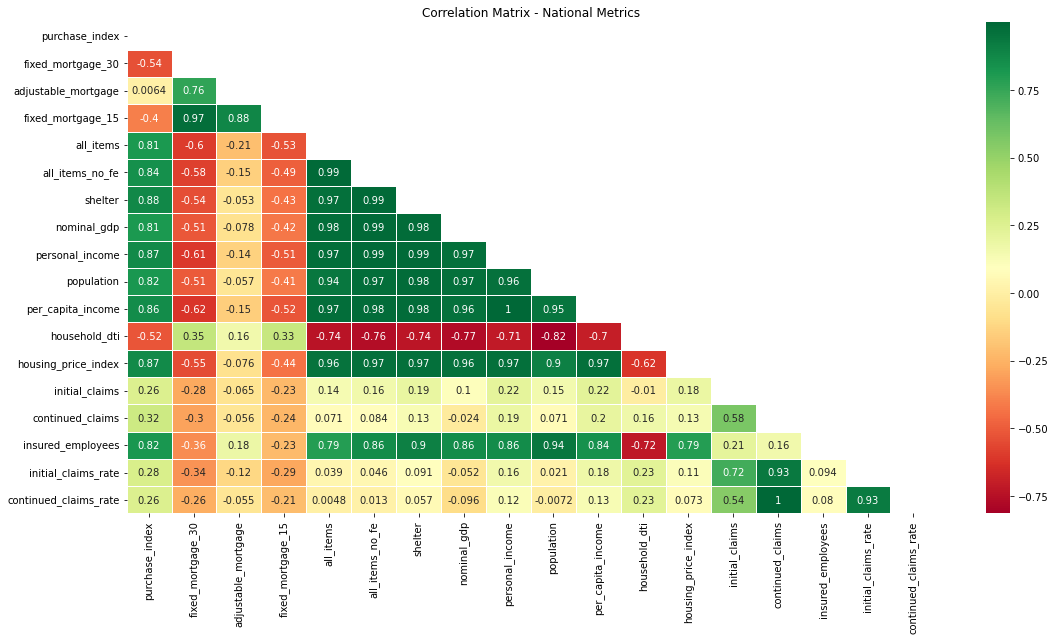

In [16]:
# Correlation matrix
plt.figure(figsize=(16, 9))

mask = np.triu(np.ones_like(natl_df.corr(), dtype=bool))
sns.heatmap(natl_df.corr(), annot=True, mask=mask, linewidth=1, cmap='RdYlGn')

plt.title('Correlation Matrix - National Metrics')
plt.tight_layout()

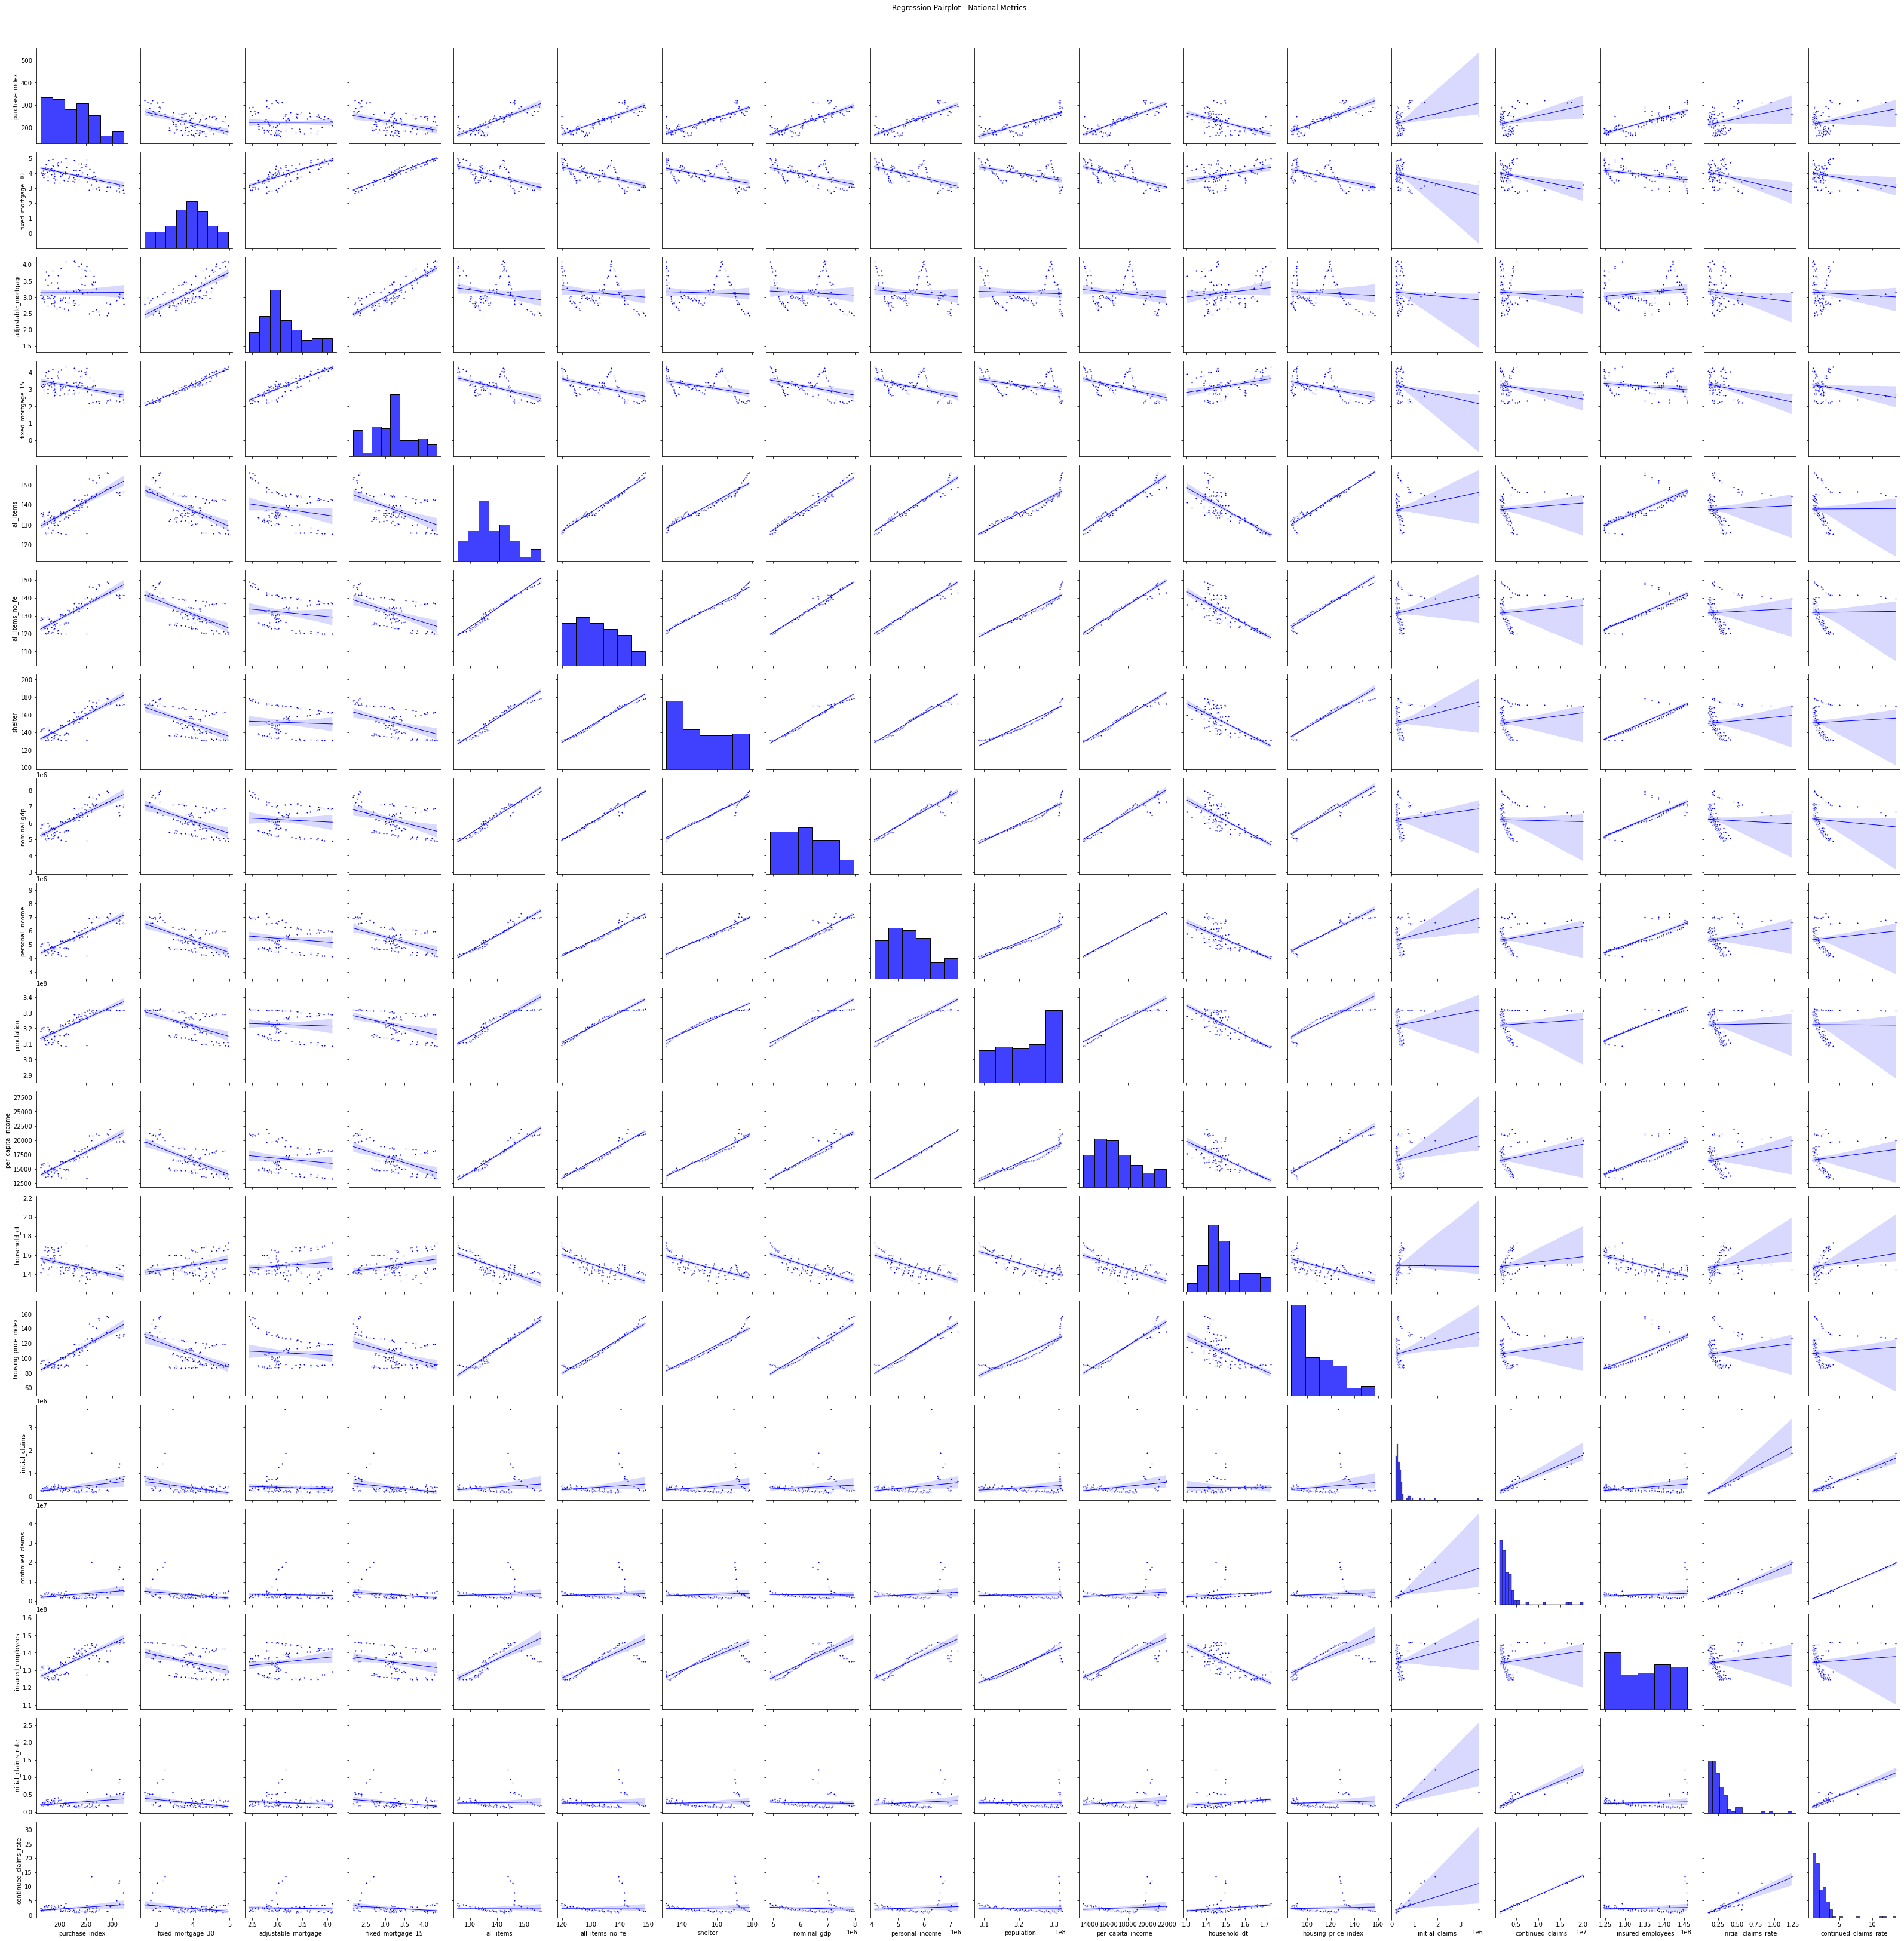

In [17]:
# pairplot version
# ax = sns.pairplot(natl_df, kind='reg', diag_kind='hist', corner=False, height=3, aspect=1)
# ax.fig.suptitle('Regression Pairplot - National Metrics', y=1.01);

g = sns.PairGrid(natl_df)
g.map_diag(sns.histplot, color='blue', bins='fd', fill=True, element='bars')
g.map_offdiag(sns.regplot, color='blue', scatter_kws={'s':10, 'alpha':1, 'edgecolors':'white'}, line_kws={'linewidth':1, 'color':'blue'})
g.fig.suptitle('Regression Pairplot - National Metrics', y=1.01);

In [17]:
natl_df.index.min(), natl_df.index.max()

(Timestamp('2010-03-31 00:00:00'), Timestamp('2021-12-31 00:00:00'))

In [53]:
natl_df.reset_index().to_csv('./data/national_metrics.csv', index=False)

In [19]:
for k, v in state_df_dict.items():
    state_df_dict[k] = pd.merge(state_df_dict[k], mba_purchase_full, how='left', left_index=True, right_index=True).copy()
    state_df_dict[k] = pd.merge(state_df_dict[k], mortgage, how='left', left_index=True, right_index=True).copy()
    state_df_dict[k] = pd.merge(state_df_dict[k], cpi, how='left', left_index=True, right_index=True).copy()

In [76]:
def check_state_stationarity_func(func_dict:dict, feature:str) -> tuple:
    adf_list = list()
    kpss_list = list()
        
    for k in func_dict.keys():

        if func_dict[k][feature].dropna().min() == func_dict[k][feature].dropna().max():
            adf_list.append(np.NaN)
            kpss_list.append(np.NaN)
        else:
            adf_list.append(adfuller(func_dict[k][feature].diff(1).diff(1).diff(1).dropna())[1])
            kpss_list.append(kpss(func_dict[k][feature].diff(1).diff(1).diff(1).dropna())[1])
        
    return (max(adf_list), min(kpss_list))

In [77]:
check_state_stationarity_func(state_df_dict, 'continued_claims_rate')

C:\Users\afstryker\miniconda3\envs\dsi\lib\site-packages\statsmodels\tsa\stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\afstryker\miniconda3\envs\dsi\lib\site-packages\statsmodels\tsa\stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\afstryker\miniconda3\envs\dsi\lib\site-packages\statsmodels\tsa\stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\afstryker\miniconda3\envs\dsi\lib\site-packages\statsmodels\tsa\stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values ava

(0.9968212075141255, 0.01260882308258702)

In [50]:
all_states_df = pd.DataFrame(columns=state_df_dict['Alabama'].columns, index=state_df_dict['Alabama'].index)

for k, v in state_df_dict.items():
    print(k)
    all_states_df = pd.merge(all_states_df, state_df_dict[k], how='inner', left_index=True, right_index=True, suffixes=('', f"_{k}")).copy()
    
all_states_df = all_states_df.iloc[:,18:]


Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming


In [54]:
all_states_df.reset_index().to_csv('.\data\state_level_metrics.csv', index=False)

In [56]:
state_df_dict['Alabama'].columns

Index(['personal_income', 'population', 'per_capita_income', 'nominal_gdp',
       'household_dti', 'housing_price_index', 'initial_claims',
       'continued_claims', 'insured_employees', 'initial_claims_rate',
       'continued_claims_rate', 'purchase_index', 'fixed_mortgage_30',
       'adjustable_mortgage', 'fixed_mortgage_15', 'all_items',
       'all_items_no_fe', 'shelter'],
      dtype='object')

In [ ]:
def dataframe_setup(df):
    """Returns a dataframe formatted for a merge for EDA."""
    
    # Set index 
    df.set_index('index', inplace=True)
    # Converts index to datetime
    df.index = pd.to_datetime(df.index)
    # Resamples to year
    df_resampled = df.resample('M').mean()

    return df_resampled

In [ ]:
df_dict = {
    # 'shiller' : shiller, #AS 7/9, drop
    # 'debt' : debt, #AS 7/9, drop
    # 'delinquency' : delinquency, #AS 7/9, drop
    'mba_purchase_wk' : mba_purchase,
    'mba_purchase_mth' : mba_purchase_2, #AS 7/9, added    
    'mortgage' : mortgage,
    # 'income' : income, #AS 7/9, drop
    'cpi' : cpi
}

In [ ]:

def by_state(dataframe):
    df_ic = pd.DataFrame()
    df_cc = pd.DataFrame()
    df_iur = pd.DataFrame()
    df_ce = pd.DataFrame()
    
    dfs = [df_ic, df_cc, df_iur, df_ce]

    #each state is a new column
    for x in dataframe['state'].unique():
        df1 = dataframe[dataframe['state'] == x]

        df_ic[x] = df1['initial_claims'].reset_index(drop = True)
        df_cc[x] = df1['continued_claims'].reset_index(drop = True)
        df_iur[x] = df1['insured_unemployment_rate'].reset_index(drop = True)
        df_ce[x] = df1['covered_employment'].reset_index(drop = True)
        
        # setting time-series column
    for df in dfs:
        df['reflecting_week_ended'] = dataframe['reflecting_week_ended'][:545].astype('datetime64[ns]')

    return df_ic, df_cc, df_ce, df_iur

In [ ]:
# Applying dataframe_setup function to all dataframes
df_dict = {k : v.pipe(dataframe_setup) for k, v in df_dict.items()}

# Creating a list of dataframes for merge
dataframes = [x for x in df_dict.values()]

# Inner merge on all dataframes
df_m = reduce(lambda left, right : pd.merge(left, right, left_index=True, right_index=True), dataframes).interpolate(method='linear') # Assuming near-linear direction of data for each column

In [ ]:
# Can't run eda_charts custom function with time series eda charts (e.g. seasonal decompose, ACF) as there are only 9 rows for all of this data
df_m.head()

In [ ]:
# Correlation matrix
plt.figure(figsize=(28, 14))
plt.title('Correlation Matrix - National Metrics')
mask = np.triu(np.ones_like(df_m.corr(), dtype=bool))
sns.heatmap(df_m.corr(), annot=True, mask=mask);

In [ ]:
# df_m.to_csv('./data/national_metrics.csv') #AS 7/6 dropped